In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import validation_curve


## View Results from Hyperparameter Tuning For Current UPDRS
Using the protein and peptide data as well as the visit month, predict the UPDRS value as either Mild, Moderate, or Severe

In [315]:
# read in the data from the csv file for xgboost hyperparameter tuning
xgb_hyperparams_df = pd.read_csv('../data/processed/xgboost_cat_hyperparam_results.csv', index_col=0)
lgb_hyperparams_df = pd.read_csv('../data/processed/lgboost_cat_hyperparam_results.csv', index_col=0)
cboost_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)

In [316]:
lgb_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.629116,0.856101,0.731011
learning_rate,0.628567,0.750618,0.556761
max_depth,5.000000,8.000000,3.000000
min_child_weight,3.578848,16.437261,5.512251
min_split_gain,0.005489,0.000046,0.000197
reg_alpha,7.735830,6.684875,1.484969
reg_lambda,3.493592,3.002659,3.025202
subsample,0.916682,0.882994,0.556561


In [317]:
xgb_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.708264,0.694449,0.643855
gamma,1.070175,0.032390,1.949759
learning_rate,0.969325,0.993978,0.502350
max_depth,2.000000,3.000000,2.000000
min_child_weight,0.301500,0.926601,2.980635
reg_alpha,1.641284,5.318046,3.232656
reg_lambda,6.011928,6.999249,7.487927
subsample,0.900018,0.710181,0.885401


In [318]:
cboost_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [319]:
# read in the protein and updrs data
updrs1_df = pd.read_csv('../data/processed/train_updrs_1_cat.csv')
updrs2_df = pd.read_csv('../data/processed/train_updrs_2_cat.csv')
updrs3_df = pd.read_csv('../data/processed/train_updrs_3_cat.csv')

In [320]:
updrs1_df['updrs_1_cat'].value_counts()

mild        854
moderate    199
severe       15
Name: updrs_1_cat, dtype: int64

In [321]:
updrs2_df['updrs_2_cat'].value_counts()

mild        910
moderate    158
Name: updrs_2_cat, dtype: int64

In [322]:
updrs3_df['updrs_3_cat'].value_counts()

mild        880
moderate    168
severe       10
Name: updrs_3_cat, dtype: int64

In [323]:
# replace the categorical updrs scores with numerical for mild, moderate and severe
## combine the moderate and severe categories since there are very few severe observations
updrs1_df['updrs_1_cat'] = updrs1_df['updrs_1_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs2_df['updrs_2_cat'] = updrs2_df['updrs_2_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs3_df['updrs_3_cat'] = updrs3_df['updrs_3_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})

In [324]:
updrs3_df['updrs_3_cat'].value_counts()

0    880
1    178
Name: updrs_3_cat, dtype: int64

In [325]:
updrs3_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_3', 'O00391', 'O00533',
       'O00584', 'O14498', 'O14773', 'O14791',
       ...
       'YVNKEIQNAVNGVK_P10909', 'YWGVASFLQK_P02753',
       'YYC(UniMod_4)FQGNQFLR_P02790', 'YYTYLIMNK_P01024',
       'YYWGGQYTWDMAK_P02675', 'kfold', 'num_prot_pep', 'num_prot', 'num_pept',
       'updrs_3_cat'],
      dtype='object', length=1204)

## Perform Validation Curve on XGBoost Fine Tune Parameters
- max-depth
- subsampling
- gamma
- reg_alpha
- reg_lambda
- scale_pos_weight

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

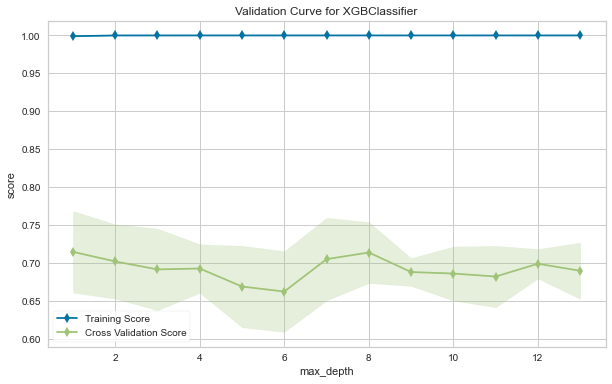

In [237]:
# prep the dataframe for validation curve
train1_df = updrs1_df.drop(columns = ['visit_id', 'patient_id', 'kfold', 'updrs_1'])
X_train_df = train1_df.drop(columns = ['updrs_1_cat'])
y_train_df = train1_df['updrs_1_cat']
updrs1_xgb_params = xgb_hyperparams_df['updrs_1'].to_dict()
# plot the validation curve for the xgboost model
fig, ax = plt.subplots(figsize=(10, 6))
viz = validation_curve(XGBClassifier(**updrs1_xgb_params), X_train_df, y_train_df, param_name='max_depth', param_range=range(1, 14), cv=4, scoring='roc_auc', ax=ax)


In [238]:
viz.test_scores_mean_, viz.test_scores_std_

(array([0.71445514, 0.7017529 , 0.69126154, 0.69241194, 0.668643  ,
        0.66203679, 0.70479067, 0.71355748, 0.68777748, 0.68578406,
        0.68184798, 0.69873032, 0.68945365]),
 array([0.05381775, 0.04903765, 0.05380173, 0.03209121, 0.05376155,
        0.05328391, 0.05450618, 0.04014622, 0.01840309, 0.03561568,
        0.04056826, 0.01941138, 0.03711483]))

### Max Depth = 1 is the best AUC for UPDRS_1

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

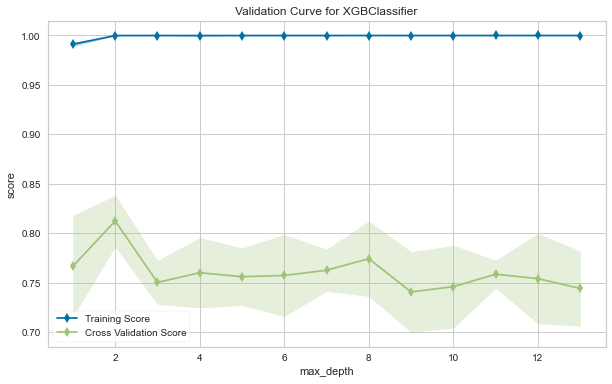

In [239]:
# prep the dataframe for validation curve
train2_df = updrs2_df.drop(columns = ['visit_id', 'patient_id', 'kfold', 'updrs_2'])
X_train_df = train2_df.drop(columns = ['updrs_2_cat'])
y_train_df = train2_df['updrs_2_cat']
updrs1_xgb_params = xgb_hyperparams_df['updrs_2'].to_dict()
# plot the validation curve for the xgboost model
fig, ax = plt.subplots(figsize=(10, 6))
viz = validation_curve(XGBClassifier(**updrs1_xgb_params), X_train_df, y_train_df, param_name='max_depth', param_range=range(1, 14), cv=4, scoring='roc_auc', ax=ax)


In [240]:
# view the results for updrs 2
viz.test_scores_mean_, viz.test_scores_std_

(array([0.76662579, 0.81235422, 0.75016367, 0.76002083, 0.75595844,
        0.75723516, 0.76252662, 0.77417235, 0.74057096, 0.74590423,
        0.75851441, 0.75403512, 0.74404572]),
 array([0.05105557, 0.02567155, 0.02191648, 0.03534794, 0.0287824 ,
        0.04120492, 0.02101713, 0.03786163, 0.04046029, 0.04153199,
        0.01393639, 0.04541293, 0.03770327]))

### UPDRS 2 Max Depth = 2 has the best AUC score

In [241]:
from yellowbrick.model_selection import ValidationCurve

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

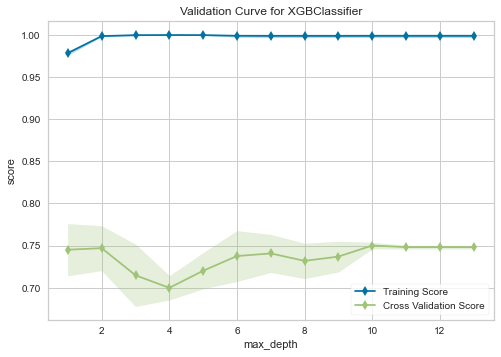

<AxesSubplot:title={'center':'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [242]:
# prep the dataframe for validation curve
train3_df = updrs3_df.drop(columns = ['visit_id', 'patient_id', 'kfold', 'updrs_3'])
X_train_df = train3_df.drop(columns = ['updrs_3_cat'])
y_train_df = train3_df['updrs_3_cat']
updrs1_xgb_params = xgb_hyperparams_df['updrs_3'].to_dict()
# plot the validation curve for the xgboost model
# Create an instance of ValidationCurve
viz = ValidationCurve(
    XGBClassifier(**updrs1_xgb_params, verbosity=0, silent=True),  #  Classifier object
    param_name="max_depth",  # The parameter to validate
    param_range=range(1, 14),  # The parameter values to evaluate
    cv=4,  # Number of cross-validation folds
    scoring="roc_auc",  # Scoring metric for evaluation
    n_jobs=-1,  # Number of CPU cores to use (set to -1 to use all available cores)
)

# Fit the validation curve on your training data
viz.fit(X_train_df, y_train_df)  # Replace X and y with your training data

# Visualize the validation curve
viz.poof()

In [243]:
# view the results for updrs 3
viz.test_scores_mean_, viz.test_scores_std_

(array([0.74509412, 0.74688935, 0.71476125, 0.69985365, 0.72011421,
        0.73757633, 0.74066001, 0.7318727 , 0.73691977, 0.7500396 ,
        0.74814566, 0.74814566, 0.74814566]),
 array([0.03059773, 0.02631448, 0.03663231, 0.01413316, 0.02111557,
        0.02983815, 0.02227891, 0.02067911, 0.01794835, 0.00363372,
        0.00195867, 0.00195867, 0.00195867]))

### Simplest Decent Model with good AUC is Max Depth = 2, but the best with low std is Max Depth = 10

In [244]:

def cross_fold_validation(df, model, target):

    updrs_results = dict()
    
    for fold in range(0, 5):
        # get the train and test data for the current fold
        train = df[df['kfold'] != fold].reset_index(drop=True)
        test = df[df['kfold'] == fold].reset_index(drop=True)

        # get the train and test data for the current fold
        drop_cols = ['visit_id', 'patient_id', f'{target}', 'kfold', f'{target}_cat']
        X_train = train.drop(columns=drop_cols)
        y_train = train[f'{target}_cat']
        X_test = test.drop(columns=drop_cols)
        y_test = test[f'{target}_cat']

        # train the model
        model.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)


        # save the results
        updrs_results[f'{target}_fold_{fold}'] = {
            'auc_score': roc_auc_score(y_test, preds),
            'acc_score': accuracy_score(y_test, preds),
            'precision_score': precision_score(y_test, preds),
            'recall_score': recall_score(y_test, preds),
        }
        
    mean_auc = np.mean([updrs_results[f'{target}_fold_{fold}']['auc_score'] for fold in range(0, 5)])
    mean_acc = np.mean([updrs_results[f'{target}_fold_{fold}']['acc_score'] for fold in range(0, 5)])
    mean_precision = np.mean([updrs_results[f'{target}_fold_{fold}']['precision_score'] for fold in range(0, 5)])
    mean_recall = np.mean([updrs_results[f'{target}_fold_{fold}']['recall_score'] for fold in range(0, 5)])
    
    return mean_auc, mean_acc, mean_precision, mean_recall
        
    
    

In [338]:
def prepare_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    if target == 'updrs_1':
        updrs_hp['max_depth'] = 1
    else:
        updrs_hp['max_depth'] = 2
    
    updrs_hp['verbosity'] = 0
    updrs_hp['silent'] = True
    updrs_hp['random_state'] = 42
    
    model = XGBClassifier(**updrs_hp)
    
    return model

In [246]:
# test the model function
# model = prepare_xgboost_model(xgb_hyperparams_df, 'updrs_1')
# model.get_params()

In [247]:
xgb_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = prepare_xgboost_model(xgb_hyperparams_df, updrs)
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

In [248]:
xgb_results

{'updrs_1': {'auc': 0.6139061690442671,
  'acc': 0.7958711772190777,
  'prec': 0.4831489426817569,
  'recall': 0.31090643697210674},
 'updrs_2': {'auc': 0.6208551123468933,
  'acc': 0.8623535606160326,
  'prec': 0.5805932629462041,
  'recall': 0.27808101296945115},
 'updrs_3': {'auc': 0.6185961118239277,
  'acc': 0.8591969954395065,
  'prec': 0.7281562881562882,
  'recall': 0.25652528589710255}}

## View XGBoost Results with Forecasting the UPDRS

In [326]:
# get the max category for each patient
max_df = updrs1_df.groupby(['patient_id'])['updrs_1_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_1_cat': 'updrs_1_max_cat'})
# merge the max category with the original dataframe
updrs1_df = updrs1_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs1_yr_df = updrs1_df[updrs1_df['visit_month'] <= 12]
updrs1_yr_df = updrs1_yr_df.drop(columns=['updrs_1_cat'])
updrs1_yr_df.rename(columns={'updrs_1_max_cat': 'updrs_1_cat'}, inplace=True)

In [327]:
# get the max category for each patient
max_df = updrs2_df.groupby(['patient_id'])['updrs_2_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_2_cat': 'updrs_2_max_cat'})
# merge the max category with the original dataframe
updrs2_df = updrs2_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs2_yr_df = updrs2_df[updrs2_df['visit_month'] <= 12]
updrs2_yr_df = updrs2_yr_df.drop(columns=['updrs_2_cat'])
updrs2_yr_df.rename(columns={'updrs_2_max_cat': 'updrs_2_cat'}, inplace=True)

In [328]:
# get the max category for each patient
max_df = updrs3_df.groupby(['patient_id'])['updrs_3_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_3_cat': 'updrs_3_max_cat'})
# merge the max category with the original dataframe
updrs3_df = updrs3_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs3_yr_df = updrs3_df[updrs3_df['visit_month'] <= 12]
updrs3_yr_df = updrs3_yr_df.drop(columns=['updrs_3_cat'])
updrs3_yr_df.rename(columns={'updrs_3_max_cat': 'updrs_3_cat'}, inplace=True)

In [360]:
xgb_forecast_hyperparams_df = pd.read_csv('../data/processed/xgboost_future_cat_hyperparam_results.csv', index_col=0)
lgb_forecast_hyperparams_df = pd.read_csv('../data/processed/lgboost_future_cat_hyperparam_results.csv', index_col=0)
cboost_forecast_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)



In [334]:
lgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.970757,0.903629,0.686326
learning_rate,0.983567,0.174551,0.910126
max_depth,8.000000,2.000000,6.000000
min_child_weight,1.232586,2.797518,13.387500
min_split_gain,0.007964,0.297876,0.004011
reg_alpha,7.437594,1.543678,4.159710
reg_lambda,7.499285,3.401574,1.926977
subsample,0.728666,0.948910,0.839655


In [336]:
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_1'] = 1
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_2'] = 2
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_3'] = 2
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,0.218284,0.108280,0.000070
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,0.292568,7.076801,0.642850
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.535242,0.682804,0.693480
random_state,42.000000,42.000000,42.000000


In [311]:
cboost_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [339]:
xgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9994339895225436, 'gamma': 0.2182840730386759, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.8763564203413519, 'max_delta_step': None, 'max_depth': 1, 'min_child_weight': 0.2925675445213144, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 6.803952572268468, 'reg_lambda': 1.2689093632909028, 'scale_pos_weight': None, 'subsample': 0.5352418739052822, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'silent': True}




c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

UPDRS: updrs_2
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9723358597087076, 'gamma': 0.1082797129959026, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.6503304038389104, 'max_delta_step': None, 'max_depth': 2, 'min_child_weight': 7.076800505115973, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.5215977214254304, 'reg_lambda': 1.677159748913182, 'scale_pos_weight': None, 'subsample': 0.6828035084965419, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'silent': True}




c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

UPDRS: updrs_3
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5794273693429098, 'gamma': 6.958373374993177e-05, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.7597417382901697, 'max_delta_step': None, 'max_depth': 2, 'min_child_weight': 0.6428495541542038, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.426225167246236, 'reg_lambda': 3.5040708421969304, 'scale_pos_weight': None, 'subsample': 0.6934802250073431, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'silent': True}




c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

In [340]:
xgb_forecast_results

{'updrs_1': {'auc': 0.6134458268310631,
  'acc': 0.6391945322430447,
  'prec': 0.5657722007722008,
  'recall': 0.4540922749541081},
 'updrs_2': {'auc': 0.6758429459236683,
  'acc': 0.7423097735597736,
  'prec': 0.6126916221033868,
  'recall': 0.5000278562017693},
 'updrs_3': {'auc': 0.6393999920247535,
  'acc': 0.6718242500094815,
  'prec': 0.5971260033996407,
  'recall': 0.4918466898954704}}

In [341]:


def create_folds(df, target):
    # calculate the number of bins by Sturge's rule
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(df[f'{updrs}_cat'], bins=num_bins, labels=False)

    df = df.dropna().reset_index(drop=True)
        
    # initiate the kfold class from sklearn
    kf = StratifiedKFold(n_splits=5)
        
    # create a kfold column
    df['kfold'] = -1

    # fill the kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
            
    # drop the bins column
    df = df.drop('bins', axis=1)
    max_kfold = df['kfold'].max()
    
    print(f'{max_kfold + 1} Kfolds created for {target}_cat')
    return df, max_kfold

In [342]:
def train_xgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/xgboost_{updrs}_model_max_depth.sav'
    pickle.dump(model, open(filename, 'wb'))

    return model

In [343]:
for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    
    best_model = train_xgboost(X_train, X_test, updrs, model)
    # compare the results of the model
    X_test = X_test.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = X_train.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6933660933660935
updrs_1 Results: 
Test AUC = 0.6933660933660935 
Train AUC = 0.9232719962888511

5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.752599890530925
updrs_2 Results: 
Test AUC = 0.752599890530925 
Train AUC = 1.0

5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8505102040816327
updrs_3 Results: 
Test AUC = 0.8505102040816327 
Train AUC = 1.0



## Test out the scale_pos_weight hyperparameter
Use # of negative / # of positive for the value of scale_pos_weight

In [344]:
def prepare_scale_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    if target == 'updrs_1':
        updrs_hp['max_depth'] = 1
        updrs_hp['scale_pos_weight'] = 1.5
        updrs_hp['random_state'] = 42
    elif target == 'updrs_2':
        updrs_hp['max_depth'] = 2
        updrs_hp['scale_pos_weight'] = 2.2
        updrs_hp['random_state'] = 42
    else:
        updrs_hp['max_depth'] = 2
        updrs_hp['scale_pos_weight'] = 1.6
        updrs_hp['random_state'] = 42
    
    model = XGBClassifier(**updrs_hp)
    return model

In [345]:
for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_scale_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    
    best_model = train_xgboost(X_train, X_test, updrs, model)
    # compare the results of the model
    X_test = X_test.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = X_train.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6923832923832924
updrs_1 Results: 
Test AUC = 0.6923832923832924 
Train AUC = 0.9967527447038813

5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7318007662835249
updrs_2 Results: 
Test AUC = 0.7318007662835249 
Train AUC = 1.0

5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7005102040816327
updrs_3 Results: 
Test AUC = 0.7005102040816327 
Train AUC = 1.0



In [265]:
# update the hyperparameters for the xgboost model best performers
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_1'] = 1
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_2'] = 2
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_3'] = 2
xgb_forecast_hyperparams_df.loc['scale_pos_weight', 'updrs_1'] = 1.5
xgb_forecast_hyperparams_df.loc['scale_pos_weight', 'updrs_2'] = 2.2
xgb_forecast_hyperparams_df.loc['scale_pos_weight', 'updrs_3'] = 1.6

In [298]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,1.000000,1.000000,1.000000
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,31.000000,31.000000,31.000000
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.600000,0.900000,0.700000
scale_pos_weight,1.500000,2.200000,1.600000


In [346]:
updrs_results = pd.DataFrame(columns = ['updrs', 'subsample', 'test_auc', 'train_auc'])
i = 0

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    for subsample in np.arange(0.5, 1.0, 0.1): 
        test_auc = []
        train_auc = []
        for fold in range(0, 5):
            xgb_forecast_hyperparams_df.loc['subsample', f'{updrs}'] = subsample
            model = prepare_scale_xgboost_model(xgb_forecast_hyperparams_df, updrs)
            temp_df, test_kfold = create_folds(df, updrs)
            temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
            X_train = temp_df[(temp_df['kfold'] != fold)].reset_index(drop=True)
            y_train = X_train[f'{updrs}_cat']
            X_test = temp_df[temp_df['kfold'] == fold].reset_index(drop=True)
            y_test = X_test[f'{updrs}_cat']
    
            best_model = train_xgboost(X_train, X_test, updrs, model)
            # compare the results of the model
            X_test = X_test.drop(columns=[f'{updrs}_cat', 'kfold'])
            test_preds = best_model.predict_proba(X_test)[:, 1]

            fold_test_auc = roc_auc_score(y_test, test_preds)
            X_train = X_train.drop(columns=[f'{updrs}_cat', 'kfold'])
            train_preds = best_model.predict_proba(X_train)[:, 1]
            fold_train_auc = roc_auc_score(y_train, train_preds)
            test_auc.append(fold_test_auc)
            train_auc.append(fold_train_auc)
        updrs_results.loc[i, 'updrs'] = updrs
        updrs_results.loc[i, 'subsample'] = subsample
        updrs_results.loc[i, 'test_auc'] = np.mean(test_auc)
        updrs_results.loc[i, 'train_auc'] = np.mean(train_auc)
        i += 1
            
        #print(f'{updrs} Results: \nSubsample: {subsample}\nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6775793650793651
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7103174603174603
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6264880952380952
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6486486486486487
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6771498771498772
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6498015873015873
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.652281746031746
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6393849206349206
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7361179361179361
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6958230958230959
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6626984126984127
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7251984126984128
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6319444444444445
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6201474201474201
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6918918918918919
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.714781746031746
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6612103174603174
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6711309523809523
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6987714987714988
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6437346437346437
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7579365079365079
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6934523809523809
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6929563492063492
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6108108108108108
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6953316953316954
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8180803571428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6746651785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7455357142857142
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6787082649151616
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7285166940339355
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7829241071428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7209821428571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7578125
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7591680350301041
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7427476737821566
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7862723214285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6958705357142857
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7338169642857143
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.668856048166393
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7296113847837986
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8113839285714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6685267857142857
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7684151785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7690202517788725
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7208538587848933
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8203125
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6819196428571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7851562500000001
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7701149425287357
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7640941434044882
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6096230158730158
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5823412698412698
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6499999999999999
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7459183673469388
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7086734693877551
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6726190476190477
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6651785714285714
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7882653061224489
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7811224489795918
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.701530612244898
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6547619047619048
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7108134920634921
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7209183673469389
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6683673469387754
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8229591836734694
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6899801587301587
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6716269841269841
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7122448979591837
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7709183673469389
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7602040816326531
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6666666666666667
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6502976190476191
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7045918367346938
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7683673469387756
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7852040816326531


In [347]:
updrs_results

,updrs,subsample,test_auc,train_auc
0,updrs_1,0.5,0.668037,0.991898
1,updrs_1,0.6,0.674682,0.99548
2,updrs_1,0.7,0.666376,0.996368
3,updrs_1,0.8,0.677926,0.996875
4,updrs_1,0.9,0.690098,0.996824
5,updrs_2,0.5,0.729101,1.0
6,updrs_2,0.6,0.752727,1.0
7,updrs_2,0.7,0.722885,1.0
8,updrs_2,0.8,0.74764,1.0
9,updrs_2,0.9,0.764319,1.0


In [348]:
updrs1_max = updrs_results[updrs_results['updrs'] == 'updrs_1']['test_auc'].max()
updrs1_best_subsample = updrs_results[(updrs_results['updrs'] == 'updrs_1') & (updrs_results['test_auc'] == updrs1_max)]['subsample'].values[0]
updrs2_max = updrs_results[updrs_results['updrs'] == 'updrs_2']['test_auc'].max()
updrs2_best_subsample = updrs_results[(updrs_results['updrs'] == 'updrs_2') & (updrs_results['test_auc'] == updrs2_max)]['subsample'].values[0]
updrs3_max = updrs_results[updrs_results['updrs'] == 'updrs_3']['test_auc'].max()
updrs3_best_subsample = updrs_results[(updrs_results['updrs'] == 'updrs_3') & (updrs_results['test_auc'] == updrs3_max)]['subsample'].values[0]

print(f'UPDRS 1 Best Subsample: {updrs1_best_subsample}\n UPDRS 1 Max AUC: {updrs1_max}')
print(f'UPDRS 2 Best Subsample: {updrs2_best_subsample}\n UPDRS 2 Max AUC: {updrs2_max}')
print(f'UPDRS 3 Best Subsample: {updrs3_best_subsample}\n UPDRS 3 Max AUC: {updrs3_max}')

UPDRS 1 Best Subsample: 0.8999999999999999
 UPDRS 1 Max AUC: 0.6900975488475488
UPDRS 2 Best Subsample: 0.8999999999999999
 UPDRS 2 Max AUC: 0.7643194957580735
UPDRS 3 Best Subsample: 0.6
 UPDRS 3 Max AUC: 0.7217431972789116


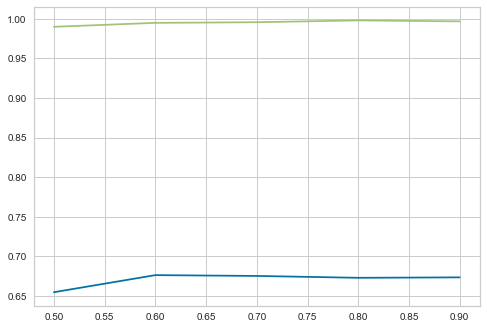

In [277]:
plt.plot(updrs_results[updrs_results['updrs'] == 'updrs_1']['subsample'], updrs_results[updrs_results['updrs'] == 'updrs_1']['test_auc'], label='test_auc')
plt.plot(updrs_results[updrs_results['updrs'] == 'updrs_1']['subsample'], updrs_results[updrs_results['updrs'] == 'updrs_1']['train_auc'], label='train_auc')
plt.show()

In [352]:
xgb_forecast_hyperparams_df.loc['subsample', 'updrs_1'] = 0.9
xgb_forecast_hyperparams_df.loc['subsample', 'updrs_2'] = 0.9
xgb_forecast_hyperparams_df.loc['subsample', 'updrs_3'] = 0.9

print(xgb_forecast_hyperparams_df)

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_scale_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    
    best_model = train_xgboost(X_train, X_test, updrs, model)
    # compare the results of the model
    X_test = X_test.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = X_train.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

                    updrs_1    updrs_2    updrs_3
colsample_bytree   0.999434   0.972336   0.579427
gamma              0.218284   0.108280   0.000070
learning_rate      0.876356   0.650330   0.759742
max_depth          1.000000   2.000000   2.000000
min_child_weight   0.292568   7.076801   0.642850
reg_alpha          6.803953   2.521598   2.426225
reg_lambda         1.268909   1.677160   3.504071
subsample          0.900000   0.900000   0.900000
random_state      42.000000  42.000000  42.000000
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6953316953316954
updrs_1 Results: 
Test AUC = 0.6953316953316954 
Train AUC = 0.9975568269676821

5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7640941434044882
updrs_2 Results: 
Test AUC = 0.7640941434044882 
Train AUC = 1.0

5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7852040816326531
updrs_3 Results: 
Test AUC = 0.7852040816326531 
Train AUC = 1.0



In [353]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,0.218284,0.108280,0.000070
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,0.292568,7.076801,0.642850
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.900000,0.900000,0.900000
random_state,42.000000,42.000000,42.000000


In [354]:
# check the gamma parameter
updrs_results = pd.DataFrame(columns = ['updrs', 'gamma', 'test_auc', 'train_auc'])
i = 0

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    for gamma in np.arange(0.1, 1.1, 0.1): 
        test_auc = []
        train_auc = []
        for fold in range(0, 5):
            xgb_forecast_hyperparams_df.loc['gamma', f'{updrs}'] = gamma
            model = prepare_scale_xgboost_model(xgb_forecast_hyperparams_df, updrs)
            temp_df, test_kfold = create_folds(df, updrs)
            temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
            X_train = temp_df[(temp_df['kfold'] != fold)].reset_index(drop=True)
            y_train = X_train[f'{updrs}_cat']
            X_test = temp_df[temp_df['kfold'] == fold].reset_index(drop=True)
            y_test = X_test[f'{updrs}_cat']
    
            best_model = train_xgboost(X_train, X_test, updrs, model)
            # compare the results of the model
            X_test = X_test.drop(columns=[f'{updrs}_cat', 'kfold'])
            test_preds = best_model.predict_proba(X_test)[:, 1]

            fold_test_auc = roc_auc_score(y_test, test_preds)
            X_train = X_train.drop(columns=[f'{updrs}_cat', 'kfold'])
            train_preds = best_model.predict_proba(X_train)[:, 1]
            fold_train_auc = roc_auc_score(y_train, train_preds)
            test_auc.append(fold_test_auc)
            train_auc.append(fold_train_auc)
        updrs_results.loc[i, 'updrs'] = updrs
        updrs_results.loc[i, 'gamma'] = gamma
        updrs_results.loc[i, 'test_auc'] = np.mean(test_auc)
        updrs_results.loc[i, 'train_auc'] = np.mean(train_auc)
        i += 1

5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.763888888888889
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6964285714285715
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6954365079365079
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6186732186732187
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7002457002457002
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7524801587301587
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6919642857142857
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6929563492063492
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6054054054054054
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6992628992628993
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7594246031746031
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6889880952380952
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6929563492063492
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6201474201474202
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6938574938574938
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7455357142857143
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6934523809523809
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6919642857142857
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6083538083538084
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7051597051597053
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7395833333333333
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.697420634920635
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6984126984126984
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6117936117936119
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.716953316953317
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7450396825396826
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7068452380952381
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6944444444444445
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6186732186732188
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.717936117936118
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.746031746031746
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.71875
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.662202380952381
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6142506142506142
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6751842751842753
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7351190476190476
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7088293650793651
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6964285714285715
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6167076167076168
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6909090909090909
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7420634920634921
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7013888888888888
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6656746031746031
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6402948402948403
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.686977886977887
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7400793650793651
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6984126984126984
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6770833333333334
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.631941031941032
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6972972972972973
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8203125
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6819196428571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7851562500000001
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7728516694033936
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7635467980295567
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8175223214285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6930803571428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7873883928571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7619047619047619
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7575259989053093
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8147321428571429
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6813616071428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7795758928571429
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7646414887794198
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7597153804050356
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8119419642857143
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6964285714285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7773437499999999
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7679255610290093
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7733990147783252
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8186383928571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6796875
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7745535714285715
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7695675971538041
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7717569786535303
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8046875
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6902901785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7885044642857143
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7580733442802409
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.756431308155446
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.80078125
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6802455357142858
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7762276785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7575259989053093
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7608100711548987
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7957589285714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7059151785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.765625
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7471264367816092
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7717569786535303
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7868303571428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.69140625
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.76953125
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7432950191570881
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7914614121510674
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8024553571428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6869419642857142
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7689732142857143
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7443897099069513
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7777777777777778
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6512896825396826
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6403769841269842
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7040816326530612
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7739795918367347
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.773469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6607142857142857
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6378968253968255
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7107142857142857
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7673469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.779591836734694
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6537698412698413
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6344246031746031
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6994897959183674
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.785204081632653
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7826530612244897
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6537698412698413
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6264880952380953
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6908163265306122
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7811224489795918
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7688775510204083
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6532738095238095
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6121031746031746
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6903061224489796
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7673469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7887755102040817
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6349206349206349
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6140873015873015
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6591836734693878
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7882653061224489
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7831632653061225
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6378968253968254
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6121031746031745
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6693877551020407
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7892857142857143
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.798469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6408730158730158
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6011904761904762
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6739795918367347
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7775510204081633
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7658163265306123
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6319444444444444
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6091269841269841
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6826530612244898
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7821428571428571
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7760204081632652
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6339285714285715
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.621031746031746
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6816326530612244
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7612244897959184
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7566326530612244


In [355]:
updrs_results

,updrs,gamma,test_auc,train_auc
0,updrs_1,0.1,0.694935,0.997831
1,updrs_1,0.2,0.688414,0.996917
2,updrs_1,0.3,0.691075,0.995929
3,updrs_1,0.4,0.688893,0.994984
4,updrs_1,0.5,0.692833,0.993668
5,updrs_1,0.6,0.696588,0.993236
6,updrs_1,0.7,0.683284,0.992489
7,updrs_1,0.8,0.689599,0.991822
8,updrs_1,0.9,0.68728,0.98989
9,updrs_1,1.0,0.688963,0.988215


In [356]:
updrs1_max = updrs_results[updrs_results['updrs'] == 'updrs_1']['test_auc'].max()
updrs1_best_gamma = updrs_results[(updrs_results['updrs'] == 'updrs_1') & (updrs_results['test_auc'] == updrs1_max)]['gamma'].values[0]
updrs2_max = updrs_results[updrs_results['updrs'] == 'updrs_2']['test_auc'].max()
updrs2_best_gamma = updrs_results[(updrs_results['updrs'] == 'updrs_2') & (updrs_results['test_auc'] == updrs2_max)]['gamma'].values[0]
updrs3_max = updrs_results[updrs_results['updrs'] == 'updrs_3']['test_auc'].max()
updrs3_best_gamma = updrs_results[(updrs_results['updrs'] == 'updrs_3') & (updrs_results['test_auc'] == updrs3_max)]['gamma'].values[0]

print(f'UPDRS 1 Best gamma: {updrs1_best_gamma}\n UPDRS 1 Max AUC: {updrs1_max}')
print(f'UPDRS 2 Best gamma: {updrs2_best_gamma}\n UPDRS 2 Max AUC: {updrs2_max}')
print(f'UPDRS 3 Best gamma: {updrs3_best_gamma}\n UPDRS 3 Max AUC: {updrs3_max}')

UPDRS 1 Best gamma: 0.6
 UPDRS 1 Max AUC: 0.6965877403377404
UPDRS 2 Best gamma: 0.4
 UPDRS 2 Max AUC: 0.765407772304324
UPDRS 3 Best gamma: 0.2
 UPDRS 3 Max AUC: 0.7112528344671202


In [358]:
xgb_forecast_hyperparams_df.loc['gamma', 'updrs_1'] = 0.6
xgb_forecast_hyperparams_df.loc['gamma', 'updrs_2'] = 0.4
xgb_forecast_hyperparams_df.loc['gamma', 'updrs_3'] = 0.0007

In [359]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,0.600000,0.400000,1.000000
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,0.292568,7.076801,0.642850
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.900000,0.900000,0.900000
random_state,42.000000,42.000000,42.000000


In [288]:
# try min_child_weight
# check the gamma parameter
updrs_results = pd.DataFrame(columns = ['updrs', 'min_child_weight', 'test_auc', 'train_auc'])
i = 0

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    for min_child_weight in range(1, 32, 3): 
        test_auc = []
        train_auc = []
        for fold in range(0, 5):
            xgb_forecast_hyperparams_df.loc['min_child_weight', f'{updrs}'] = min_child_weight
            model = prepare_scale_xgboost_model(xgb_forecast_hyperparams_df, updrs)
            temp_df, test_kfold = create_folds(df, updrs)
            temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
            X_train = temp_df[(temp_df['kfold'] != fold)].reset_index(drop=True)
            y_train = X_train[f'{updrs}_cat']
            X_test = temp_df[temp_df['kfold'] == fold].reset_index(drop=True)
            y_test = X_test[f'{updrs}_cat']
    
            best_model = train_xgboost(X_train, X_test, updrs, model)
            # compare the results of the model
            X_test = X_test.drop(columns=[f'{updrs}_cat', 'kfold'])
            test_preds = best_model.predict_proba(X_test)[:, 1]

            fold_test_auc = roc_auc_score(y_test, test_preds)
            X_train = X_train.drop(columns=[f'{updrs}_cat', 'kfold'])
            train_preds = best_model.predict_proba(X_train)[:, 1]
            fold_train_auc = roc_auc_score(y_train, train_preds)
            test_auc.append(fold_test_auc)
            train_auc.append(fold_train_auc)
        updrs_results.loc[i, 'updrs'] = updrs
        updrs_results.loc[i, 'min_child_weight'] = min_child_weight
        updrs_results.loc[i, 'test_auc'] = np.mean(test_auc)
        updrs_results.loc[i, 'train_auc'] = np.mean(train_auc)
        i += 1

5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6805555555555556
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6245039682539683
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6532738095238095
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5945945945945946
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7523341523341524
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6805555555555556
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6245039682539683
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6532738095238095
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5945945945945946
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7523341523341524
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6805555555555556
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6245039682539683
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6532738095238095
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5945945945945946
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7523341523341524
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6805555555555556
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6245039682539683
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6532738095238095
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5945945945945946
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7523341523341524
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6865079365079365
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6245039682539683
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6532738095238095
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5990171990171991
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7140049140049141
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7063492063492064
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7083333333333334
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6626984126984128
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6014742014742015
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7621621621621621
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6840277777777778
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6572420634920635
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7018849206349207
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6245700245700245
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6835380835380835
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6507936507936508
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6711309523809523
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6939484126984127
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6029484029484028
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7233415233415234
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.668154761904762
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6999007936507937
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6964285714285714
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.62997542997543
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6874692874692875
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.689484126984127
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.662202380952381
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.670138888888889
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6486486486486487
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7238329238329239
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6651785714285714
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6453373015873015
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6517857142857143
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6127764127764128
5 Kfolds created for updrs_1_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7695331695331695
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8376116071428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7393973214285715
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.75390625
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7980295566502463
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7476737821565408
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8878348214285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7114955357142856
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7427455357142858
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7066228790366722
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6694033935413246
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8895089285714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7522321428571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7734375
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7361795292829776
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7624521072796935
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8973214285714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7896205357142857
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7494419642857144
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7394636015325671
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8232074438970991
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8543526785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6964285714285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7204241071428571
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7602627257799671
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.782703886152162
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.80078125
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7377232142857143
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7862723214285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7640941434044882
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7449370552818828
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8091517857142857
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7840401785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7684151785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7848932676518884
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7728516694033936
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7979910714285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6428571428571428
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7410714285714285
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7931034482758621
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7657361795292829
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8426339285714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6969866071428571
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7728794642857142
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7859879584017515
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7870826491516145
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8777901785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6886160714285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7862723214285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7799671592775042
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.735632183908046
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7996651785714286
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6891741071428572
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7745535714285714
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7378215654077723
5 Kfolds created for updrs_2_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7307060755336617
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6309523809523809
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6765873015873016
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6040816326530613
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.789795918367347
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6979591836734694
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.619047619047619
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6755952380952381
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7132653061224489
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7724489795918368
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6979591836734694
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6086309523809524
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.621031746031746
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5892857142857142
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7698979591836734
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8397959183673469
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7619047619047619
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6398809523809523
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.698469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7566326530612244
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7551020408163266
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6850198412698413
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6423611111111112
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6403061224489796
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.764795918367347
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.753061224489796
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6830357142857143
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6324404761904762
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6673469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6561224489795918
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7423469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6433531746031746
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.5843253968253969
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6229591836734695
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7255102040816327
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7811224489795918
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6825396825396826
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6438492063492063
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6653061224489796
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7198979591836735
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8061224489795918
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6825396825396826
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6031746031746031
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6520408163265307
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.698469387755102
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.8244897959183672
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6755952380952381
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6304563492063492
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6326530612244898
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7158163265306122
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7642857142857143
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6438492063492064
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6155753968253969
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.6704081632653062
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7443877551020409
5 Kfolds created for updrs_3_cat


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7479591836734695


In [289]:
updrs_results

,updrs,min_child_weight,test_auc,train_auc
0,updrs_1,1,0.661052,0.986124
1,updrs_1,4,0.661052,0.986124
2,updrs_1,7,0.661052,0.986124
3,updrs_1,10,0.661052,0.986124
4,updrs_1,13,0.655462,0.984603
5,updrs_1,16,0.688203,0.984787
6,updrs_1,19,0.670253,0.984386
7,updrs_1,22,0.668433,0.984651
8,updrs_1,25,0.676386,0.980798
9,updrs_1,28,0.678861,0.976167


In [290]:
updrs1_max = updrs_results[updrs_results['updrs'] == 'updrs_1']['test_auc'].max()
updrs1_best_min_child_weight = updrs_results[(updrs_results['updrs'] == 'updrs_1') & (updrs_results['test_auc'] == updrs1_max)]['min_child_weight'].values[0]
updrs2_max = updrs_results[updrs_results['updrs'] == 'updrs_2']['test_auc'].max()
updrs2_best_min_child_weight = updrs_results[(updrs_results['updrs'] == 'updrs_2') & (updrs_results['test_auc'] == updrs2_max)]['min_child_weight'].values[0]
updrs3_max = updrs_results[updrs_results['updrs'] == 'updrs_3']['test_auc'].max()
updrs3_best_min_child_weight = updrs_results[(updrs_results['updrs'] == 'updrs_3') & (updrs_results['test_auc'] == updrs3_max)]['min_child_weight'].values[0]

print(f'UPDRS 1 Best min_child_weight: {updrs1_best_min_child_weight}\n UPDRS 1 Max AUC: {updrs1_max}')
print(f'UPDRS 2 Best min_child_weight: {updrs2_best_min_child_weight}\n UPDRS 2 Max AUC: {updrs2_max}')
print(f'UPDRS 3 Best min_child_weight: {updrs3_best_min_child_weight}\n UPDRS 3 Max AUC: {updrs3_max}')

UPDRS 1 Best min_child_weight: 16
 UPDRS 1 Max AUC: 0.6882034632034632
UPDRS 2 Best min_child_weight: 10
 UPDRS 2 Max AUC: 0.799810994800219
UPDRS 3 Best min_child_weight: 10
 UPDRS 3 Max AUC: 0.7223979591836736


In [291]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,1.000000,0.900000,1.000000
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,31.000000,31.000000,31.000000
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.900000,0.900000,0.900000
scale_pos_weight,1.500000,2.200000,1.600000


## LGBoost Future Categorical Predictions

In [81]:
lgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_lgboost_model(lgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(model.get_params())
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    lgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.970757221693757, 'importance_type': 'split', 'learning_rate': 0.9835668264286576, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 1.2325864748203452, 'min_split_gain': 0.007964040585614, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 7.437593735288674, 'reg_lambda': 7.499284502976287, 'silent': 'warn', 'subsample': 0.7286661893753408, 'subsample_for_bin': 200000, 'subsample_freq': 0}


UPDRS: updrs_2
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9036286590547646, 'importance_type': 'split', 'learning_rate': 0.1745511363640152, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 2.7975180017133723, 'min_split_gain': 0.2978757291694001, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 1.5436778945279928, 'reg_lambda': 3.401574051688944, 'silen

In [82]:
lgb_forecast_results

{'updrs_1': {'auc': 0.59664793015473,
  'acc': 0.6300638403447596,
  'prec': 0.5485747458161251,
  'recall': 0.41962947373344095},
 'updrs_2': {'auc': 0.6251290954000639,
  'acc': 0.7347631535131536,
  'prec': 0.6323177476118652,
  'recall': 0.33857255787690566},
 'updrs_3': {'auc': 0.5969516130707487,
  'acc': 0.6313568096484241,
  'prec': 0.531607724043764,
  'recall': 0.4460611805697889}}

## Compare Catboost Model

In [83]:
cgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    cgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'learning_rate': 0.3667810794764569, 'depth': 7, 'l2_leaf_reg': 5.641366638454, 'bagging_temperature': 4.429427339938372, 'min_data_in_leaf': 8}


0:	learn: 0.5964092	total: 360ms	remaining: 5m 59s
1:	learn: 0.5284874	total: 692ms	remaining: 5m 45s
2:	learn: 0.4746385	total: 1.02s	remaining: 5m 37s
3:	learn: 0.4301078	total: 1.34s	remaining: 5m 34s
4:	learn: 0.3818352	total: 1.67s	remaining: 5m 32s
5:	learn: 0.3581313	total: 2s	remaining: 5m 31s
6:	learn: 0.3207303	total: 2.32s	remaining: 5m 29s
7:	learn: 0.2842559	total: 2.64s	remaining: 5m 27s
8:	learn: 0.2643040	total: 2.96s	remaining: 5m 26s
9:	learn: 0.2496839	total: 3.28s	remaining: 5m 25s
10:	learn: 0.2323576	total: 3.61s	remaining: 5m 24s
11:	learn: 0.2093736	total: 3.94s	remaining: 5m 24s
12:	learn: 0.1869665	total: 4.27s	remaining: 5m 24s
13:	learn: 0.1679286	total: 4.6s	remaining: 5m 24s
14:	learn: 0.1571655	total: 4.93s	remaining: 5m 23s
15:	learn: 0.1523514	total: 5.26s	remaining: 5m 23s
16

In [84]:
cgb_forecast_results

{'updrs_1': {'auc': 0.6875180353730299,
  'acc': 0.7291737868499222,
  'prec': 0.7309163059163059,
  'recall': 0.4883101242882365},
 'updrs_2': {'auc': 0.6656831081016579,
  'acc': 0.7504308191808191,
  'prec': 0.643524896156475,
  'recall': 0.44420327498588363},
 'updrs_3': {'auc': 0.661142439158262,
  'acc': 0.6960405051769257,
  'prec': 0.6438998501498501,
  'recall': 0.503075681492109}}

In [117]:
from sklearn.model_selection import StratifiedKFold

def create_folds(df, target):
    # calculate the number of bins by Sturge's rule
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(df[f'{updrs}_cat'], bins=num_bins, labels=False)

    df = df.dropna().reset_index(drop=True)
        
    # initiate the kfold class from sklearn
    kf = StratifiedKFold(n_splits=5)
        
    # create a kfold column
    df['kfold'] = -1

    # fill the kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
            
    # drop the bins column
    df = df.drop('bins', axis=1)
    max_kfold = df['kfold'].max()
    
    print(f'{max_kfold + 1} Kfolds created for {target}_cat')
    return df, max_kfold

In [160]:
def train_catboost(train_df, test_df, updrs):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_val = val_df.drop([f'{updrs}_cat','kfold'] axis=1)
    y_val = val_df[f'{updrs}_cat']

    # Define the CatBoost classifier
    model = CatBoostClassifier(iterations=1000, eval_metric='AUC', random_seed=42)

    # Fit the model on the training data
    model.fit(features, 
              target,
                #early_stopping_rounds=50, 
                verbose=100)

    # Make predictions on the test data
    predictions = model.predict_proba(test_df)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(test_df[f'{updrs}_cat'], predictions)
    print("AUC on Test Data:", auc)

    # Save the best iteration of the model
    model.save_model(f'../models/catboost_{updrs}_model.cbm', format='cbm', pool=None)

    return model

In [174]:
# train and save the best catboost model for each updrs
cboost_results = dict()

for updrs, df in zip(['updrs_1'], [updrs1_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}



    

5 Kfolds created for updrs_1_cat
Learning rate set to 0.023058
0:	test: 0.4894349	best: 0.4894349 (0)	total: 279ms	remaining: 4m 38s
100:	test: 0.6599509	best: 0.6633907 (98)	total: 20.3s	remaining: 3m
200:	test: 0.6914005	best: 0.6914005 (169)	total: 38.9s	remaining: 2m 34s
300:	test: 0.7027027	best: 0.7071253 (287)	total: 57.5s	remaining: 2m 13s
400:	test: 0.7115479	best: 0.7154791 (386)	total: 1m 16s	remaining: 1m 53s
500:	test: 0.7159705	best: 0.7169533 (477)	total: 1m 34s	remaining: 1m 34s
600:	test: 0.7130221	best: 0.7169533 (477)	total: 1m 53s	remaining: 1m 15s
700:	test: 0.7135135	best: 0.7169533 (477)	total: 2m 11s	remaining: 56.3s
800:	test: 0.7233415	best: 0.7243243 (785)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7233415	best: 0.7248157 (808)	total: 2m 49s	remaining: 18.6s
999:	test: 0.7267813	best: 0.7272727 (960)	total: 3m 7s	remaining: 0us

bestTest = 0.7272727273
bestIteration = 960

Shrink model to first 961 iterations.
AUC on Test Data: 0.7326781326781326


In [175]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6525798525798526, 1.0)

In [176]:
for updrs, df in zip(['updrs_2'], [updrs2_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_2_cat
Learning rate set to 0.023058
0:	test: 0.5623974	best: 0.5623974 (0)	total: 206ms	remaining: 3m 26s
100:	test: 0.7695676	best: 0.7766831 (95)	total: 18.2s	remaining: 2m 42s
200:	test: 0.7996716	best: 0.8111658 (176)	total: 36.1s	remaining: 2m 23s
300:	test: 0.8292282	best: 0.8314176 (299)	total: 54.1s	remaining: 2m 5s
400:	test: 0.8445539	best: 0.8467433 (381)	total: 1m 12s	remaining: 1m 48s
500:	test: 0.8494800	best: 0.8549535 (464)	total: 1m 30s	remaining: 1m 29s
600:	test: 0.8560482	best: 0.8565955 (581)	total: 1m 48s	remaining: 1m 11s
700:	test: 0.8555008	best: 0.8582375 (674)	total: 2m 6s	remaining: 54s
800:	test: 0.8587849	best: 0.8587849 (738)	total: 2m 26s	remaining: 36.4s
900:	test: 0.8576902	best: 0.8593322 (804)	total: 2m 45s	remaining: 18.2s
999:	test: 0.8587849	best: 0.8604269 (946)	total: 3m 4s	remaining: 0us

bestTest = 0.8604269294
bestIteration = 946

Shrink model to first 947 iterations.
AUC on Test Data: 0.8292282430213465


In [177]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6737821565407772, 1.0)

In [178]:
for updrs, df in zip(['updrs_3'], [updrs3_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_3_cat
Learning rate set to 0.023037
0:	test: 0.5795918	best: 0.5795918 (0)	total: 212ms	remaining: 3m 32s
100:	test: 0.6540816	best: 0.6709184 (92)	total: 19s	remaining: 2m 49s
200:	test: 0.6943878	best: 0.6989796 (191)	total: 40.1s	remaining: 2m 39s
300:	test: 0.7306122	best: 0.7311224 (294)	total: 1m 1s	remaining: 2m 23s
400:	test: 0.7372449	best: 0.7403061 (359)	total: 1m 22s	remaining: 2m 3s
500:	test: 0.7494898	best: 0.7510204 (493)	total: 1m 39s	remaining: 1m 39s
600:	test: 0.7530612	best: 0.7556122 (572)	total: 1m 56s	remaining: 1m 17s
700:	test: 0.7551020	best: 0.7571429 (689)	total: 2m 13s	remaining: 57s
800:	test: 0.7586735	best: 0.7602041 (780)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7576531	best: 0.7612245 (822)	total: 2m 47s	remaining: 18.4s
999:	test: 0.7596939	best: 0.7612245 (822)	total: 3m 4s	remaining: 0us

bestTest = 0.7612244898
bestIteration = 822

Shrink model to first 823 iterations.
AUC on Test Data: 0.7775510204081633


In [179]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6303571428571428, 1.0)

## Compare to Logistic Regression Model

In [85]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_results = cross_fold_validation(updrs1_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_results = cross_fold_validation(updrs2_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_results = cross_fold_validation(updrs3_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [86]:
updrs1_results

(0.511721383287093,
 0.780847703040674,
 0.32282051282051283,
 0.062211088895139766)

In [87]:
updrs2_results

(0.5258909849605227,
 0.8464349962704578,
 0.42333333333333323,
 0.07048988874546684)

In [88]:
updrs3_results

(0.5240749211448716,
 0.8194894035589735,
 0.3485714285714286,
 0.07900396151669495)

## Forecast with Logistic Regression

In [89]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_forecast_results = cross_fold_validation(updrs1_yr_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_forecast_results = cross_fold_validation(updrs2_yr_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_forecast_results = cross_fold_validation(updrs3_yr_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [90]:
updrs1_forecast_results

(0.5634874999789138,
 0.5994172665293609,
 0.4912421630094044,
 0.3920253253358589)

In [91]:
updrs2_forecast_results

(0.582742150911908, 0.6805340492840493, 0.4779128959276018, 0.3289821193299454)

In [92]:
updrs3_forecast_results

(0.5758538282007636,
 0.6218648310387985,
 0.5047414576826341,
 0.3744481451117032)